# ARR for Data Professionals

#### Preamble

<div class="alert alert-block alert-info">
Building ARR is simple, but that doesn't always make it easy. In my experience, the definitions are where the problems in this metric begin to show themselves. Depending on who you talk to or where you work, the definitions might vary. <b>The important thing is consistency.</b> ARR is a <a href="https://sensiba.com/resources/insights/what-you-need-to-know-about-annual-recurring-revenue-and-gaap-revenue-recognition/">Non-GAAP</a> metric, so it is not under the same rules that normal financial reporting has in the US. For American public companies, you will normally see ARR data points and commentary in the <em>Management Discussion & Analysis</em> portion of their filings. Being a Non-GAAP metric does not discount the importance this measure is to companies. ARR is shiny and will get a lot of attention, so you better know what you are doing.</div>

## What is ARR?

**ARR** is revenue viewed on an annual basis that is expected to reoccur. **ARR** stands for **Annual Recurring Revenue**. Getting **ARR** requires a couple steps. Start with **Total Contract Value** and translate to **Annual Contact Value** which then translates to **Annual Recurring Revenue**. Let's start with the **Total Contract Value (TCV)** and annualize it. If a customer agrees to a 20k contract for two years, annualizing the 20k would turn the **Annual Contact Value (ACV)** into 10k. Meaning, 10k is the annual amount of this contract, but further translation is needed. The next step is to figure out what would *reoccur* or what is *renewable*. Take this example contract:
 
|Contract #|Item|Amount|Start Date|End Date|
|---|---|---|---|---|
|001|Cool Software Feature 1|$4000|01/01/2024|12/31/2025|
|001|Cool Software Feature 2|$4000|01/01/2024|12/31/2025|
|001|Cool Software Feature 3|$4000|01/01/2024|12/31/2025|
|001|Cool Software Feature 4|$4000|01/01/2024|12/31/2025|
|001|Onboarding|$4000|01/01/2024|12/31/2025|

Contract # 001 has 5 lines in it. 4 out of the 5 would be considered renewable. Once the contract is up, the customer can repurchase the 4 software features, but would not repurchase the onboarding item, because onboarding is only needed for the first year. So, that puts the **Annual Recurring Revenue (ARR)** to be 8k, once you annualize and deduct the non-renewable item.

$\begin{matrix}
 TCV & \to & ACV & \to & ARR  \\
 20k & \to & 10k & \to & 8k
\end{matrix}$

## Annualizing

The example above is simple. Take the two years at 20k total and multiply by .5 to get the annualized amount. However, the complexity comes with details. The basic formula to annualize is as follows:

$\text{Annual Contract Value} = \text{Total Contract Value} * (\frac{\text{Time Interval (Year)}}{\text{Contract Term Length}})$

Two terms are introduced. First, **Time Interval (Year)**. The **Time Interval (Year)** is the number used to represent 1 year. That could be represented in a few ways. For example, there are 12 months in a year. So **Time Interval (Year)** would be 12, if annualizing by months. Here are some examples:

$
\begin{matrix}
\text{Year} & \to & 1 \\
\text{Quarter} & \to & 4 \\
\text{Month} & \to & 12 \\
\text{Day} & \to & 365
\end{matrix}
$

Take the same 20k Contract at 2 years example, here is how the formula would look by Year, Quarter, Month, Day. All examples end up multiplying the 20k by $\frac{1}{2}$, but more creative contracts can lead to unexpected results depending on which interval is chosen.

$
\begin{matrix}
\text{Year} & \to & 10000 = 20000 * (\frac{1}{2}) \\
\text{Quarter} & \to & 10000 = 20000 * (\frac{4}{8}) \\
\text{Month} & \to & 10000 = 20000 * (\frac{12}{24}) \\
\text{Day} & \to & 10000 = 20000 * (\frac{365}{730})
\end{matrix}
$

<div class="alert alert-block alert-info">
However, there are implications to the interval that is chosen. Take these <em>what if</em> scenarios and consider what happens with each interval:

- What if annualizing by day on a leap year?
- What if the contract length is less than 1 year?
- What if the contract length is multiple years?
   - And that contract length is over a leap year?
- What if the contract ramps?
   - Meaning the customer is expected to pay an increased amount in the second year for the same product.
- What if the contract is cancelled?
   - Cancelled fully?
   - Cancelled Partially?
</div>

To consider these conundrums, let's jump into some python.

### Core Functions & Classes

In [19]:
# Installing libraries used in entire notebook
%pip install matplotlib pandas Jinja2
# matplotlib also import numpy & dateutil which will be used later

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### Imports & Classes

In [20]:
from dataclasses import dataclass
from calendar import isleap
from datetime import date, timedelta
from typing import Literal, List

import matplotlib.pyplot as plt
from matplotlib.dates import ConciseDateFormatter
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)


@dataclass
class ContractHeader:
    """Dataclass to handle the header of a contract.

    Args:
        tcv (int): Total Contract Value.
        start_date (date): The Start Date of the Contract.
        end_date (date): The End Date of the Contract.
    """

    amount: int
    start_date: date
    end_date: date


@dataclass
class ContractLine:
    """Dataclass to handle contract lines.

    Args:
        tcv (int): Total Contract Value.
        start_date (date): The Start Date of the Contract.
        end_date (date): The End Date of the Contract.
        item_sku (int): To designate item skus
    """
    amount: int
    start_date: date
    end_date: date
    item_sku: int
    renewable: bool

@dataclass
class Contract:
    """Bringing it together.
    """
    id: int
    header: ContractHeader
    lines: List[ContractLine]


INTERVAL = Literal["Year", "Quarter", "Month", "Day"]

#### Funcs

In [21]:
def count_leap_days(start_date: date, end_date: date) -> int:
    """Helper function to output the # of leap days in date range.

    Args:
        start_date (date): Start date of contract.
        end_date (date): End date of contract.

    Returns:
        int: Number of leap days in the range of dates.
    """
    leap_check = start_date.year
    leap_days = []
    while leap_check <= end_date.year:
        if isleap(leap_check):
            leap_days.append(date(leap_check, 2, 29))
        leap_check += 1

    leap_count = len([*filter(lambda x: start_date <= x <= end_date, leap_days)])
    return leap_count


def get_contract_term(
    start_date: date, end_date: date, generalize_leap_year: bool, interval_str: INTERVAL
):
    math_end_date = end_date + timedelta(days=1)
    contract_term_length_month = (math_end_date.year - start_date.year) * 12 + (
        math_end_date.month - start_date.month
    )
    contract_term_length_year = contract_term_length_month // 12
    contract_term_length_quarter = contract_term_length_month // 3

    contract_term_length_day = (math_end_date - start_date).days
    contract_term_nl_day = contract_term_length_day - count_leap_days(
        start_date, end_date
    )

    contract_term_mapping = {
        "Year": contract_term_length_year,
        "Quarter": contract_term_length_quarter,
        "Month": contract_term_length_month,
        "Day": (
            contract_term_nl_day if generalize_leap_year else contract_term_length_day
        ),
    }

    return contract_term_mapping[interval_str]

In [22]:
def annualize(
    contract: ContractHeader | ContractLine,
    period: date,
    interval_str: INTERVAL,
    generalize_leap_year: bool = True,
    print_details: bool = False,
) -> int:
    """Takes the input of `tcv` and converts to `acv`.

    Args:
        period (date): The date in which we are looking at the ARR.
            Example, what is the ACV on Jan 31, 2024. Jan 31, 2024
            would be the `period`.
        interval_str (INTERVAL): The options to chose from when deciding
            what interval to multiply `tcv` by.
        generalize_leap_year (bool): Toggle to decide who to handle leap years.
            `True` will not consider leap years and set all years to 365 days.
            `False` will call `calendar.isleap(year)` of the `period` value
            to determine if the year has 366 days in it.

    Returns:
        int: Returns Annual Contract Value. The annualized amount of
            Total Contract Value.
    """

    # 1
    if generalize_leap_year:
        day = 365
    else:
        day = 365 + isleap(period.year)

    # 2
    interval_mapping = {"Year": 1, "Quarter": 4, "Month": 12, "Day": day}
    time_interval = interval_mapping[interval_str]

    # 3
    contract_term = get_contract_term(
        contract.start_date, contract.end_date, generalize_leap_year, interval_str
    )

    # 4
    if contract.start_date <= period <= contract.end_date:
        active = 1
    else:
        active = 0

    # 5
    if print_details:
        print(contract)
        print(f"Period: {period}")
        print(f"Generalize Leap Year: {generalize_leap_year}")
        print(f"Time Interval: {interval_str} - {time_interval}")
        print(f"Contract Term: {contract_term}")
        print(f"Active: {active}")

    # 6
    try:
        fraction = time_interval / contract_term
    except ZeroDivisionError:
        fraction = 0

    return contract.amount * (fraction) * active

Code in this write up is written with python libraries on v3.12. Later on in this write up, python code will includes the usual packages in the data space (`pandas`, `numpy`, `matplotlib`, etc.). Type hinting and docstrings are also used to help guide the function. Notice comments throughout the function labelled with a number. That number coinsides with notes below.

1. The `generalize_leap_year` argument does exactly that. If set to `True`, all years are considered at 365 days. If set to `False`, leap years are considered. For example, 2024 will have 366 days, while 2025 will have 365 days. The `generalize_leap_year` will also be used to deduct leap years from the denominator if annualizing by days. See # 4 for that information. 
2. Of the four options available, it specifies what the numerator will be for the `acv` formula in the return statement.
3. This is the most convoluted part of the function. The denominator of the formula needs to be determined. For `contract_term_length_day`, a simple delta of the two dates will output that number, then add 1 for the final day. A start date of January 1st and an end date of January 2nd will output a delta of 1 day, but the contract is really active for 2 days, which is why the `math_end_date` variable is created. Another variable is setup incase `generalize_leap_year` is set to `True`, so it can deduct leap years (`contract_term_nl_day`). For the other 3, start with `contract_term_length_month` because there is always the same number of months in a year and months in a quarter. To determine the number of months, code was taken from the `dateutil` [package](https://github.com/dateutil/dateutil/blob/master/src/dateutil/relativedelta.py#L146). From that, derive the other two variables. For `contract_term_length_year` there are 12 months in a year. The floor division operator is used by 12 and the same respectively for 3 months in a quarter.
4. `active` is a new concept that is introduced. ARR is calculated in terms of a point in time. For example, "What was ARR on Jan 31, 2024?" or "What is the difference in ARR from last month to this month?". When the point in time is outside of the contract term length, the contract is no longer considered active. A contract starting 01/15/2024 and ending 01/14/2025 would be active in 06/01/2024, but inactive in 06/01/2025. If inactive, then the function sets the calculation to 0 by the `if else` check and multiplied in final formula in the return statement.
5. Just incase the information that builds the final result is needed.
6. Put the pieces together with the added `* active` at the end to determine if the `acv` is active.
<div class="alert alert-block alert-info">
Take note of the usage of floor division. This is indicating that if a contract length is 1.89 years, and the `interval_str` arg was set to `Year`, then only <em>1 year</em> would be considered.
6. Need to rewrite and realign w/ new numbers.
</div>

Let's see the function in action.

In [23]:
def get_end_of_month_range(start: date, end: date) -> np.ndarray:
    """Helper function to get a list of end of month dates.

    Args:
        start (date): Start date.
        end (date): End Date.

    Returns:
        ndarray: Numpy array of dates inbetween.
    """
    assert end > start, "end date must be later than start date"
    end_of_month_range = []
    working_date = start
    while working_date < end:
        end_of_month_range.append(working_date + relativedelta(day=31))
        working_date = working_date + relativedelta(months=1)
    return np.array(end_of_month_range)

In [24]:
def build_contracts_table(contracts: List[Contract]) -> pd.DataFrame:
    contracts = pd.DataFrame(contracts)
    headers = pd.DataFrame.from_records(contracts["header"])
    headers.rename(
        columns={
            "amount": "header_amount",
            "start_date": "header_start_date",
            "end_date": "header_end_date",
        },
        inplace=True,
    )
    lines_temp = contracts["lines"].explode()
    lines = pd.json_normalize(lines_temp)
    lines.index = lines_temp.index
    lines.rename(
        columns={
            "amount": "line_amount",
            "start_date": "line_start_date",
            "end_date": "line_end_date",
        },
        inplace=True,
    )
    df = (
        contracts.merge(headers, left_index=True, right_index=True)
        .merge(lines, left_index=True, right_index=True)
        .drop(columns=["header", "lines"])
        .reset_index(drop=True)
    )
    return df

In [25]:
def build_acv_table(df: pd.DataFrame, by_lines: bool = True) -> pd.DataFrame:

    if by_lines:
        start_date = "line_start_date"
        end_date = "line_end_date"
    else:
        start_date = "header_start_date"
        end_date = "header_end_date"

    range = pd.DataFrame(
        get_end_of_month_range(df[start_date].min(), df[end_date].max())
    ).rename(columns={0: "period"})

    acv_table = range.merge(df, how="cross")

    acv_table["acv"] = acv_table.apply(
        lambda row: annualize(
            ContractLine(
                row.line_amount,
                row[start_date],
                row[end_date],
                row.item_sku,
                row.renewable,
            ),
            row.period,
            "Month",
            True,
        ),
        axis=1,
    )

    return acv_table[["period", "id", "item_sku", "renewable", "acv"]]

### Leap Year

In [26]:
# Example 20k tcv, 2 year length
contract = ContractHeader(20_000, date(2024, 1, 15), date(2026, 1, 14))

dont_generalize_leap_year = annualize(contract, date(2024, 6, 30), "Day", False)

# Wait a minute... 2024 is a leap year...
# Setting `generalize_leap_year` to True

generalize_leap_year = annualize(contract, date(2024, 6, 30), "Day", True)

print("Results of leap year")
print(f"Don't generalize leap year: {dont_generalize_leap_year:.2f}")
print(f"Generalize leap year: {generalize_leap_year}")

Results of leap year
Don't generalize leap year: 10013.68
Generalize leap year: 10000.0


General thought would suggest that 20k tcv of 2 years will have a 10k acv, but **take caution when getting as granular in days, because leap years will make an appearance**. Let's look at the implication of this over time. Consider the below 3 year deal and let's ask, "What is the acv of this contract month over month? and how do leap years show in the data?"

$
\begin{matrix}
\text{Contract} & \text{Start Date} & \text{End Date} & \text{Total Contract Value} \\
\text{001} & \text{06/15/2023} & \text{06/14/2025} & 30000 
\end{matrix}
$

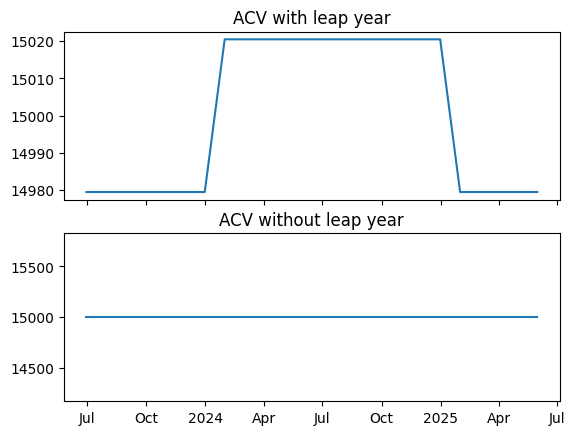

In [27]:


contract = ContractHeader(30_000, date(2023, 6, 15), date(2025, 6, 14))
date_range = get_end_of_month_range(date(2023, 6, 1), date(2025, 6, 1))
results_w_leap_year = np.array(
    [annualize(contract, month, "Day", False) for month in date_range]
)
results_wo_leap_year = np.array(
    [annualize(contract, month, "Day", True) for month in date_range]
)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(date_range, results_w_leap_year)
ax2.plot(date_range, results_wo_leap_year)
ax1.set_title("ACV with leap year")
ax2.set_title("ACV without leap year")
ax1.xaxis.set_major_formatter(ConciseDateFormatter(ax1.xaxis.get_major_locator()))
ax2.xaxis.set_major_formatter(ConciseDateFormatter(ax2.xaxis.get_major_locator()))
plt.show()

<div class="alert alert-block alert-warning">
The difference here is only $40 dollars, but imagine this scaled across an enterprise company. Contracts with terms over leap years will see their ARR rise in the beginning of a leap year and fall at the end of a leap year. My recommendation, if you are going to annualize by day, <a href="https://en.wikipedia.org/wiki/KISS_principle">K.I.S.S</a>. <b>Hard code the day value to be 365 and move on.</b> I can see some reasons where you want to see this swing in data, but many companies will be just fine with 365 days every year.
</div>

Let's continue the leap year analysis, with another contract.

In [28]:
short_contract = ContractHeader(25_000, date(2024,1,1), date(2024,3,31))

no_gen_leap_year = annualize(short_contract, date(2024,3,31), "Day", False, print_details=True)
print(f"\nNot generalizing leap year: {no_gen_leap_year}\n")

print(f"---")

gen_leap_year = annualize(short_contract, date(2024,3,31), "Day", True, print_details=True)
print(f"\nGeneralizing leap year: {gen_leap_year}\n")

ContractHeader(amount=25000, start_date=datetime.date(2024, 1, 1), end_date=datetime.date(2024, 3, 31))
Period: 2024-03-31
Generalize Leap Year: False
Time Interval: Day - 366
Contract Term: 91
Active: 1

Not generalizing leap year: 100549.45054945054

---
ContractHeader(amount=25000, start_date=datetime.date(2024, 1, 1), end_date=datetime.date(2024, 3, 31))
Period: 2024-03-31
Generalize Leap Year: True
Time Interval: Day - 365
Contract Term: 90
Active: 1

Generalizing leap year: 101388.88888888889



Why is this 25k contract still showing an odd amount when annualizing by day, even with `generalize_leap_year` set to `True`? Let's do some math.

$\begin{matrix}
\text{Formula:} &
\text{Annual Contract Value} = \text{Total Contract Value} * (\frac{\text{Time Interval (Year)}}{\text{Contract Term Length}})\\
\\
\text{Generalizing leap year = False:} &
100,549 = 25,000 * (\frac{366}{91})\\
\\
\text{Generalizing leap year = True:} &
101,388 = 25,000 * (\frac{365}{90})
\end{matrix}
$

General wisdom tells us that this 3 month contract should be multiplied by 4. 12 months in a year divided by 3 months of the contract multiplied by total contract value. $25,000 * \frac{12}{3} = 100,000$. But regardless of removing leap days from the equation, you will always have less days in Q1 of a year than in any other quarter of the year. Which means, annualzing by day in the first Q1 will always give an unconventional result when comparing to the full year.

<div class="alert alert-block alert-warning">
You've been warned. Another risk of annualizing by day. Still do-able, but leap years add a ton of implications to be aware of.
</div>


### Contracts Less Than 1 Year

Sales people *always be closing*. Which means never underestimate the creativity of a sales team. They will do what they need to do to make the company money. Which means contracts can have shorter lengths, can ramp, and can have all kinds of discounts or variability. For this section, the focus will be on shorter contracts. Shorter contracts that are intended to renew, can force a big swing in the reporting when not renewed. Take this example:

$
\begin{matrix}
\text{Contract} & \text{Start Date} & \text{End Date} & \text{Total Contract Value} \\
\text{001} & \text{01/01/2024} & \text{03/31/2024} & 25000 
\end{matrix}
$

First, I'll setup some code to show this smaller contract in the context of other contracts.

In [29]:
from typing import List


def viz_many_contracts(contracts: List[ContractHeader | ContractLine]) -> None:

    min_date = min([contract.start_date for contract in contracts])
    max_date = max([contract.end_date for contract in contracts])

    date_range = get_end_of_month_range(min_date, max_date)

    data = None

    for contract in contracts:
        new_data = np.array(
            [
                annualize(
                    contract, period, "Month", True
                ) for period in date_range
            ]
        )
        if data is None:
            data = new_data
        else:
            data = np.vstack((data, new_data))
    fig, ax = plt.subplots()
    ax.stackplot(date_range, data)
    plt.show()
    return None

In [30]:
def viz_many_contracts_bar(
    contracts: List[ContractLine | ContractHeader] | ContractHeader | Contract
) -> None:

    # Should take any dataclass
    

    min_date = min([contract.start_date for contract in contracts])
    max_date = max([contract.end_date for contract in contracts])

    date_range = get_end_of_month_range(min_date, max_date)

    data = None

    for contract in contracts:
        new_data = np.array(
            [annualize(contract, period, "Month", True) for period in date_range]
        )
        if data is None:
            data = new_data
        else:
            data = np.vstack((data, new_data))
    fig, ax = plt.subplots()
    ax.stackplot(date_range, data)
    plt.show()
    return None

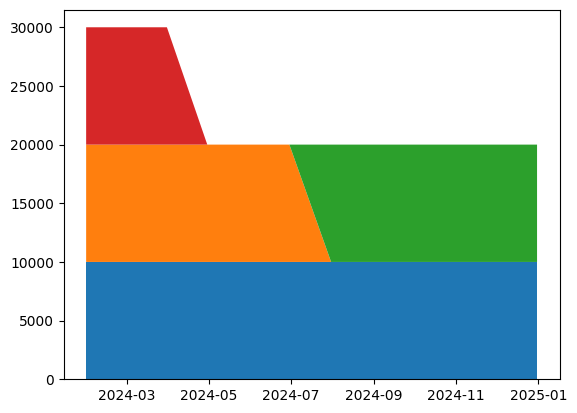

ContractHeader(amount=2500, start_date=datetime.date(2024, 1, 1), end_date=datetime.date(2024, 3, 31))
Period: 2024-03-31
Generalize Leap Year: True
Time Interval: Month - 12
Contract Term: 3
Active: 1
ACV `con4`: 10000.0


In [31]:
con1 = ContractHeader(10_000, date(2024,1,1), date(2024, 12, 31))

con2 = ContractHeader(5_000, date(2024,1,1), date(2024, 6, 30))

con3 = ContractHeader(5_000, date(2024,7 ,1), date(2024, 12, 31))

con4 = ContractHeader(2_500, date(2024,1,1), date(2024, 3, 31))

viz_many_contracts([con1, con2, con3, con4])

acv_march_2024 = annualize(con4, date(2024, 3, 31), "Month", True, True)
print(f"ACV `con4`: {acv_march_2024}")

Annualizing contracts **shorter** than 1 year, the ACV increases from the TCV. Annualizing contracts **longer** than 1 year, the ACV decreases from TCV. Which means the business impact for the company will be that they need to chase after a larger number in the renewal process.

In my experience, shorter contracts are often used as a back door *trial run*. It's a way to give a customer the product for a short period of time. This means the renewal implications are not always the same as a full year contract or more, so you're likely to see the big swing in shorter contracts on the down side.

In the above example, you see 4 contracts. 1 full year, 2 half year, & the 1 quarter contract. In that year, the 2 half year contracts renewed, showing no delta between the two. The 1 quarter contract did not renew with another contract, so the dip in ACV is seen in the visual. Even more so the dip is 10k not the 2.5k of tcv because the ACV of the 1 quarter contract is 10k.

<div class="alert alert-block alert-warning">
At scale, seeing the quick rise and fall of shorter contracts can often push a business decision to not annualize contracts shorter than a 1 year time frame.
</div>

### Ramp Contracts

A [ramp contract](https://dealhub.io/glossary/ramp-deal/) will have a change in price during the term of the contract. A common reason for ramp contracts is to lock the customer in for multiple years. The first year starts lower often at a discount, then the subsequent years increase in price over time to the normal amount.

Let's take a look at an example contract:
|Contract #|Item|Amount|Start Date|End Date|
|---|---|---|---|---|
|001|Cool Software Feature 1|$4000|1/1/2024|12/31/2024|
|001|Cool Software Feature 2|$4000|1/1/2024|12/31/2024|
|001|Cool Software Feature 1|$6000|1/1/2025|12/31/2025|
|001|Cool Software Feature 2|$6000|1/1/2025|12/31/2025|
|001|Cool Software Feature 1|$8000|1/1/2026|12/31/2026|
|001|Cool Software Feature 2|$8000|1/1/2026|12/31/2026|

Contract # 1 has a **Total Contract Value** of 36k, over the course of 3 years. It has two different items in the contract and ramps up 2k each year. Our earlier code was designed to handle contracts at just the header level, so now we will use the other dataclasses created earlier.

In [32]:
ramp_contract = Contract(
    1,
    ContractHeader(36_000, date(2024, 1, 1), date(2026, 12, 31)),
    [
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
        ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
        ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
        ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 1, True),
        ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 1, True),
    ],
)

In [33]:
testing = [
    Contract(
        1,
        ContractHeader(36_000, date(2024, 1, 1), date(2026, 12, 31)),
        [
            ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
            ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 2, True),
            ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
            ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 2, True),
            ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 1, True),
            ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 2, True),
        ],
    ),
    Contract(
        2,
        ContractHeader(36_000, date(2024, 1, 1), date(2026, 12, 31)),
        [
            ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
            ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 2, True),
            ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
            ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 2, True),
            ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 3, True),
            ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 4, True),
        ],
    ),
]


cols = ["period", "id", "item_sku", "renewable"]


df = build_acv_table(build_contracts_table(testing))


a = (
    pd.DataFrame(df.groupby(cols).sum())
    .unstack(level=0)
    .drop(columns=[col for col in df.columns if col not in cols and col != "acv"])
)

a.loc["total", :] = a.sum().values

total_style = pd.Series("font-weight: bold;", index=["acv"])

x = a.style.format("{:.0f}").apply(
    lambda x: ["font-weight: bold" if v == x.iloc[-1] else "" for v in x]
)

x

When using only the header of ramp contracts, the full implications of a ramp contract are not captured. The above example takes a 3 year 36k contract and ramps from one year to the next. Starting at 8k ACV in the first year, 12k in the second, and finishing at 16k in the third year. While annualizing but just the header total contract value annualizes the 36k evenly across 3 years at 12k.

$\begin{matrix}
 36k & \to & \begin{matrix}12k & \to & \text{Year 1}\\ 12k & \to & \text{Year 2}\\ 12k & \to & \text{Year 3}\end{matrix}
 \\\\
 36k & \to & \begin{matrix}8k & \to & \text{Year 1}\\ 12k & \to & \text{Year 2}\\ 16k & \to & \text{Year 3}\end{matrix}
\end{matrix}$

## Renewability

Renewability is the piece of the equation that takes **Annual Contract Value** and converts to **Annual Recurring Revenue**. The premise is relatively simple, filter out any items in the contract that are considered non-renewable. This is easily done with have a flag for renewability.

In [110]:
ramp_w_onboarding = Contract(
    1,
    ContractHeader(36_000, date(2024, 1, 1), date(2026, 12, 31)),
    [
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
        ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
        ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
        ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 1, True),
        ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 1, True),
        ContractLine(6_000, date(2024, 1, 1), date(2024, 12, 31), 1, False),
    ],
)

df = build_contracts_table([ramp_w_onboarding])

### SCD Type 2

The decision to make a product renewable or non-renewable is a business decision. It is common for businesses to change their minds and adapt as new information comes, so the data will need to be able to adapt.

Scenario:
> New leadership comes into the company at the start of 2024. The company is currently selling 4 different software items and 1 onboarding item:
> |Item Name|Item Sku|Renewable|
> |---|---|---|
> |Cool Software Feature 1|1|True|
> |Cool Software Feature 2|2|True|
> |Cool Software Feature 3|3|True|
> |Cool Software Feature 4|4|True|
> |Onboarding|5|False|
> 
> After reviewing the data from previous years, they have decided to update 'Cool Software Feature 4' as no longer a renewable item:
> |Item Name|Item Sku|Renewable|
> |---|---|---|
> |Cool Software Feature 1|1|True|
> |Cool Software Feature 2|2|True|
> |Cool Software Feature 3|3|True|
> |Cool Software Feature 4|4|**False**|
> |Onboarding|5|False|
>
> This change is effective immediately on January 1st 2024.

This scenario is a classic use case of [SCD (Slowly Changing Dimensions)](https://en.wikipedia.org/wiki/Slowly_changing_dimension). This writeup will not be covering what SCD is. Plenty of articles and books exist covering this concept.

<div class="alert alert-block alert-info">
It is important to be able to supply the business with product/item data on both a Type 1 & Type 2 basis.
</div>


In [37]:
contract_pre_change = Contract(
    1,
    ContractHeader(24_000, date(2023, 1, 1), date(2025, 12, 31)),
    [
        ContractLine(4_000, date(2023, 1, 1), date(2023, 12, 31), 4, True),
        ContractLine(4_000, date(2023, 1, 1), date(2023, 12, 31), 3, True),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 4, True),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 3, True),
        ContractLine(4_000, date(2025, 1, 1), date(2025, 12, 31), 4, True),
        ContractLine(4_000, date(2025, 1, 1), date(2025, 12, 31), 3, True),
    ],
)
contract_post_change = Contract(
    1,
    ContractHeader(24_000, date(2023, 1, 1), date(2025, 12, 31)),
    [
        ContractLine(4_000, date(2023, 1, 1), date(2023, 12, 31), 4, False),
        ContractLine(4_000, date(2023, 1, 1), date(2023, 12, 31), 3, True),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 4, False),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 3, True),
        ContractLine(4_000, date(2025, 1, 1), date(2025, 12, 31), 4, False),
        ContractLine(4_000, date(2025, 1, 1), date(2025, 12, 31), 3, True),
    ],
)

<Axes: title={'center': 'ARR Type 1 Example'}, xlabel='period', ylabel='arr'>

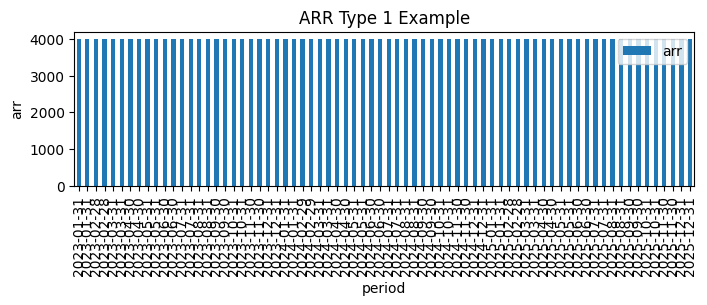

In [38]:
pre_df = build_contracts_table([contract_pre_change])
post_df = build_contracts_table([contract_post_change])

range = pd.DataFrame(
    get_end_of_month_range(
        pre_df["line_start_date"].min(), pre_df["line_end_date"].max()
    )
).rename(columns={0: "period"})

type1 = range.merge(pre_df, how="cross")

type1["arr"] = type1.apply(
    lambda row: annualize(
        ContractLine(
            row.line_amount,
            row["line_start_date"],
            row["line_end_date"],
            row.item_sku,
            row.renewable,
        ),
        row.period,
        "Day",
        True,
    ),
    axis=1,
)

pd.DataFrame(
    type1[["period", "id", "item_sku","arr"]]
    .groupby(
        ["period", "id", "item_sku"],
    )
    .sum("arr")
).reset_index().plot(
    kind= 'bar', x="period", y="arr", ylabel="arr", figsize=(8, 2), title="ARR Type 1 Example"
)



# Notes
---
- Total Contract Value -> Annual Contract Value -> Annual Recurring Revenue
- Renewing non-renewing
- The key is consistancy, ARR is a non-gaap metric
- T1 & T2 dimension risk
- Renewable vs Non-Renewable
- Annualization (365)
- Up for renewal on the NEXT day
- Ramp Contracts
- Up for Renewal
- Cancellations
    - Depends on the type of Cancellation... A full cancellation or partial, like only the second half
- Avoid Snapshot
- Starts w/ a Contract...
- Start Date End Date
- Products -> Product Families
- Look up the Finance guy Jeff suggested...
- Upgrades, Downgrades, Churn, New Business
    - X-Sell, Expansion, Ramp, 
- It's all about comparisons...
- Pull forwards...
- Organic vs Inorganic
- Non-Gaap
- Deferred ARR
- Customer Cube